In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# External classes
from BufferGeometry import BufferGeometry
from utils.analysis import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import linalg as la

import torch
import torch.nn.functional as F

In [2]:
# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

def get_buffer_states(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs.input_ids

    with torch.no_grad():
        outputs = model(input_ids, output_hidden_states=True, return_dict=True)
    
    hidden_states = outputs.hidden_states

    # Extract buffer states
    buffer_states = np.array([layer.squeeze(0).numpy() for layer in hidden_states])

    return buffer_states


# Initialize result containers
volumes = []
gd = []
cos_sim = []
mean_vector = []

# Read prompts from file
with open("prompts.txt", "r") as f:
    prompts = [line.strip() for line in f.readlines() if line.strip()]


# Loop over the prompts
for p in prompts:
    # Define matrices to store the results for each prompt
    phrase_volumes = []
    phrase_gd = []
    phrase_cos_sim = []
    phrase_mean_vector = []

    # Get the buffer state 
    buffer_states = get_buffer_states(p)

    # Initial Grassmann reference buffer (from first step)
    buffer_scaled_0 = buffer_states[0,:,:] - np.mean(buffer_states[0,:,:], axis=0, keepdims=True)
    U, S, Vt = la.svd(buffer_scaled_0)
    eigenvalues = S**2
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9) + 1

    U_reduced = U[:, :n_components]
    S_reduced = np.diag(S[:n_components])
    Vt_reduced = Vt[:n_components, :]
    buffer_reduced_0 = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)

    # Loop over buffer steps
    for i in range(buffer_states.shape[0]):
        bg = BufferGeometry(buffer_states[i, :, :])

        # ===== VOLUME =====
        phrase_volumes.append(bg.volume())

        # ===== COSINE SIMILARITY =====
        phrase_cos_sim.append(bg.cosine_similarity(buffer_states[-1, :, :]))

        # ===== MEAN VECTOR =====
        phrase_mean_vector.append(bg.mean_vector())

        # Reduce current buffer
        buffer_scaled = buffer_states[i,:,:] - np.mean(buffer_states[i,:,:], axis=0, keepdims=True)
        U, S, Vt = la.svd(buffer_scaled)
        eigenvalues = S**2
        explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
        n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9) 

        U_reduced = U[:, :n_components]
        S_reduced = np.diag(S[:n_components])
        Vt_reduced = Vt[:n_components, :]
        buffer_reduced = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)

        # ===== GRASSMANN DISTANCE =====
        bg_reduced = BufferGeometry(buffer_reduced)
        phrase_gd.append(bg_reduced.grassmann_distance(buffer_reduced_0))

        # Update reference buffer
        buffer_reduced_0 = buffer_reduced

    # Append results for this phrase
    volumes.append(phrase_volumes)
    gd.append(phrase_gd)
    cos_sim.append(phrase_cos_sim)
    mean_vector.append(phrase_mean_vector)

# Convert to NumPy arrays
volumes = np.array(volumes)
gd = np.array(gd)
cos_sim = np.array(cos_sim)
mean_vector = np.array(mean_vector)

In [3]:
# Count words in each prompt
word_counts = [len(prompt.split()) for prompt in prompts]

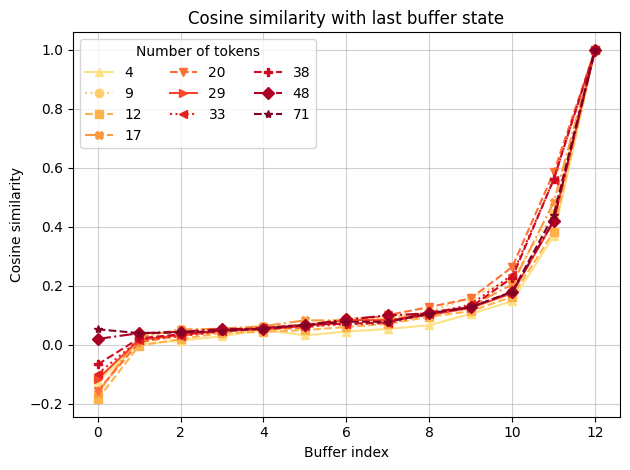

In [4]:
# --- Cosine Similarity Plot ---

colormap_name="YlOrRd"
cmap = plt.colormaps[colormap_name]
color_positions = np.linspace(0.2, 1, 10)
colors = [cmap(pos) for pos in color_positions]
markers = ["^", "o", "s", "X", "v", ">", "<", "P", "D", "*"]
linestyles = ["solid", "dotted", "dashed", "dashdot", "dashed"]*2


plt.figure()
for i in range(cos_sim.shape[0]):
    color = colors[i]
    marker = markers[i]
    linestyle = linestyles[i]
    
    plt.plot(range(cos_sim.shape[1]), cos_sim[i], color=color, marker=marker, linestyle=linestyle, label=f"{word_counts[i]}")
plt.title("Cosine similarity with last buffer state")
plt.xlabel("Buffer index")
plt.ylabel("Cosine similarity")
plt.grid(alpha=0.6)
plt.legend(loc="best", title="Number of tokens", ncol=3)
plt.tight_layout()
plt.show()

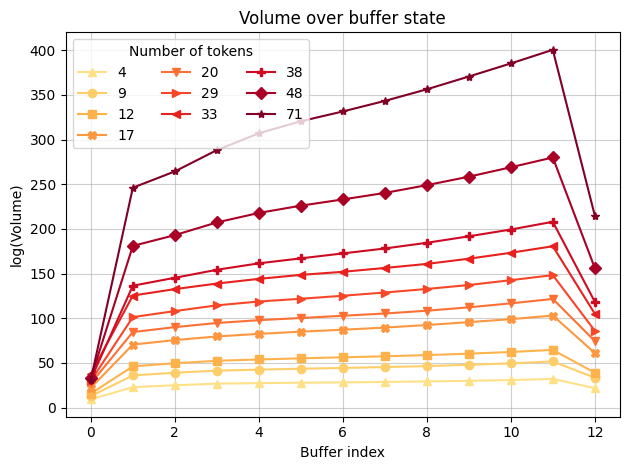

In [5]:
# --- Volume Plot ---
plt.figure()
for i in range(volumes.shape[0]):
    volumes.shape[1]
    color = colors[i]
    marker = markers[i]
    linestyle = linestyles[i]

    plt.plot(range(volumes.shape[1]), volumes[i], color=color, marker=marker, label=f"{word_counts[i]}")
    
plt.title("Volume over buffer state")
plt.xlabel("Buffer index")
plt.ylabel("log(Volume)")
#plt.yscale("log")
plt.grid(alpha=0.6)
plt.legend(loc="best", title="Number of tokens", ncol=3)
plt.tight_layout()
plt.show()

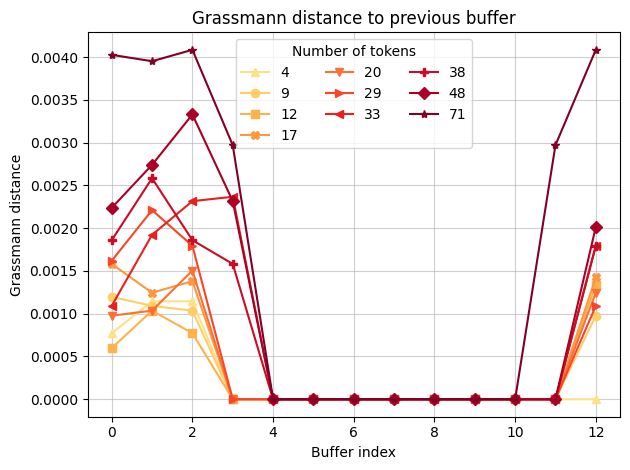

In [6]:
# --- Grassmann Distance Plot ---
plt.figure()
for i in range(gd.shape[0]):
    color = colors[i]
    marker = markers[i]
    linestyle = linestyles[i]

    plt.plot(range(gd.shape[1]), gd[i], color=color, marker=marker, label=f"{word_counts[i]}")
    
plt.title("Grassmann distance to previous buffer")
plt.xlabel("Buffer index")
plt.ylabel("Grassmann distance")
plt.grid(alpha=0.6)
plt.legend(loc="best", title="Number of tokens", ncol=3)
plt.tight_layout()
plt.show()

[]

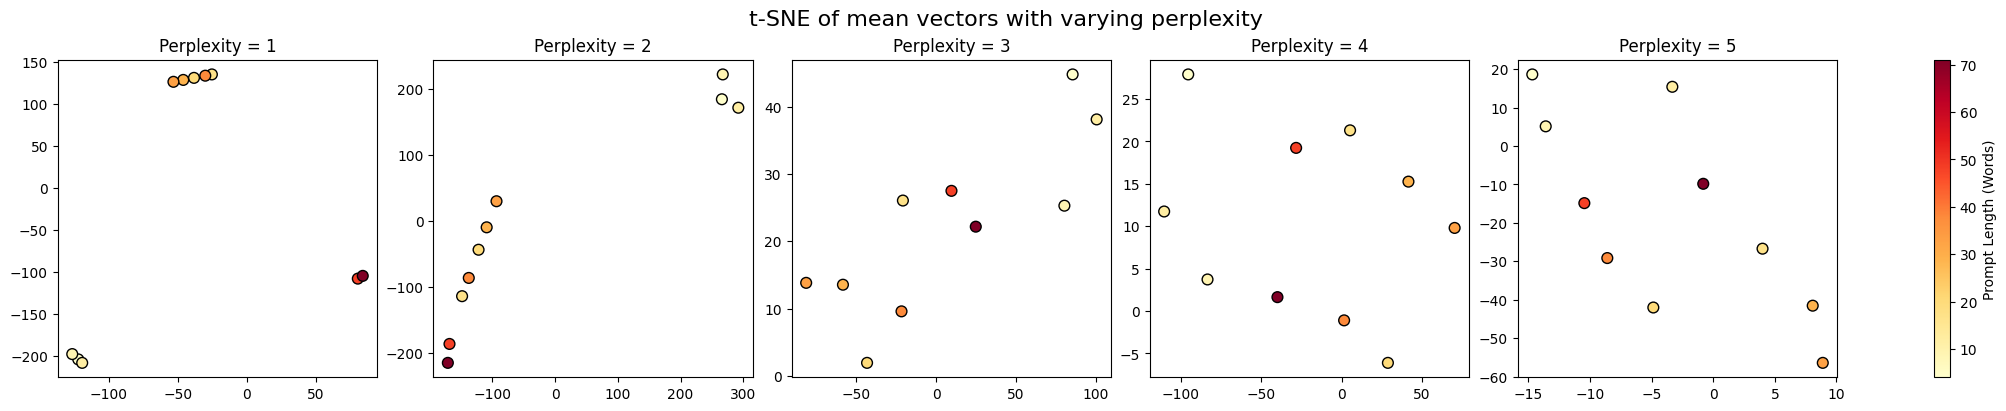

In [7]:
step = -1
mean_vecs_step = mean_vector[:, step, :]

# Word counts for color
word_counts = [len(p.split()) for p in prompts]

# Perplexity values to try
perplexities = [1, 2, 3, 4, 5]

# Create subplots
fig, axs = plt.subplots(1, len(perplexities), figsize=(20, 4), constrained_layout=True)

for ax, perplexity in zip(axs, perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', init='random', random_state=42)
    proj = tsne.fit_transform(mean_vecs_step)
    
    scatter = ax.scatter(proj[:, 0], proj[:, 1], c=word_counts, cmap="YlOrRd", s=60, edgecolor='k')
    ax.set_title(f"Perplexity = {perplexity}")

# Shared colorbar
fig.colorbar(scatter, ax=axs, label="Prompt Length (Words)", orientation='vertical')
plt.suptitle("t-SNE of mean vectors with varying perplexity", fontsize=16)
plt.plot()